In [43]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)
from combiners import EpochsCombiner
from typing import *
import mne
import tensorflow as tf
import mneflow as mf
import matplotlib.pyplot as plt
import numpy as np
from utils.data_management import dict2str
from lfcnn_vis import plot_patterns
from LFCNN_decoder import SpatialParameters, TemporalParameters, ComponentsOrder, Predictions, WaveForms
import pickle
from utils.machine_learning import one_hot_decoder
import sklearn.metrics as sm
from utils.machine_learning.confusion import ConfusionEstimator
import scipy as sp
import pylustrator
from PIL import Image
from dataclasses import dataclass
from copy import deepcopy
import mne

@dataclass
class InducedsComparer(object):
    induced_cond_1: np.ndarray
    induced_cond_2: np.ndarray
    ratio: float
    meta: Any = None

    def diff(self, normalize=False, absolute=False):
        if normalize:
            induced_cond_1 = normal_rows(self.induced_cond_1)
            induced_cond_2 = normal_rows(self.induced_cond_2)
        else:
            induced_cond_1 = self.induced_cond_1
            induced_cond_2 = self.induced_cond_2

        diff = np.abs(induced_cond_1 - induced_cond_2) if absolute else induced_cond_1 - induced_cond_2

        return diff/(induced_cond_1 + induced_cond_2)

    def normalize(self):
        self.induced_cond_1 = normal_rows(self.induced_cond_1)
        self.induced_cond_2 = normal_rows(self.induced_cond_2)

    def copy(self):
        return deepcopy(self)

def normal_rows(matrix, inplace=False):
    if not inplace:
        matrix = matrix.copy()

    for i, row in enumerate(matrix):
        matrix[i] = row/row.mean()

    return matrix if not inplace else None

def compare(x1 :np.array, x2: np.array) -> float:
    return (x1@x2)/(np.linalg.norm(x1)*np.linalg.norm(x2))

def binary_mask(matrix, ratio=1):
    return np.ma.make_mask(matrix > ratio*matrix.mean())

def read_pkl(path: str) -> Any:
    with open(
            path,
            'rb'
        ) as file:
        content = pickle.load(
            file
        )
    return content

def draw_inddif(induced1, induced2, tf, savepath=False, title1='B1-B3', title2='Diff', title3='B10-B12', suptitle=''):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
    ax1.imshow(
        induced1,
        cmap='RdBu_r',
        origin='lower'
    )
    ax1.set_title(title1)
    ax2.imshow(
        tf,
        cmap='RdBu_r',
        origin='lower'
    )
    ax2.set_title(title2)
    ax3.imshow(
        induced2,
        cmap='RdBu_r',
        origin='lower'
    )
    ax3.set_title(title3)
    w, h = 15, 5
    fig.suptitle(suptitle)
    fig.set_size_inches(w, h)
    if savepath:
        plt.savefig(savepath, dpi=300)
        plt.close()
    else:
        plt.show()

def mimshow(
    *args: np.ndarray,
    titles=None,
    suptitle='',
    axis=0,
    cmaps: Optional[Union[str, list[str]]] = None,
    apply_kwargs_to: Optional[Union[int, list[int]]] = None,
    **kwargs
):
    if not titles:
        titles = ['' for _ in args]
    if len(args) != len(titles):
        titles = titles + ['' for _ in len(args) - len(titles)]
    if cmaps is None:
        cmaps = ['RdBu_r' for _ in args]
    elif isinstance(cmaps, str):
        cmaps = [cmaps for _ in args]
    elif len(cmaps) != len(args):
        raise ValueError(f'Number of colormaps ({len(cmaps)}) is inconsistent with number of matcires to plot ({len(args)})')
    if apply_kwargs_to and not isinstance(apply_kwargs_to, list):
        apply_kwargs_to = [apply_kwargs_to]
    elif apply_kwargs_to is None:
        apply_kwargs_to = [i for i in range(len(args))]

    fig, axes = plt.subplots(ncols=len(args)) if axis == 0 else plt.subplots(nrows=len(args))
    for i, (content, ax, title, cmap) in enumerate(zip(args, axes, titles, cmaps)):
        if not isinstance(content, list):
            content = [content]
        if not isinstance(cmap, list):
            cmap = [cmap]
        if len(cmap) != len(content):
            raise ValueError(f'Number of colormaps ({len(cmap)}) is inconsistent with number of matcires to plot ({len(content)}) for argument {i}')
        for j, (sample, c) in enumerate(zip(content, cmap)):
            if i + j in apply_kwargs_to:
                ax.imshow(
                    sample,
                    cmap=c,
                    origin='lower',
                    **kwargs
                )
            else:
                ax.imshow(
                    sample,
                    cmap=c,
                    origin='lower'
                )
        ax.set_title(title)

    fig.suptitle(suptitle)

    return fig

RM&RI_vs_LM&LI
0.7973281426039431
RM_vs_RI_vs_LM_vs_LI
0.7995187805541782
LM_vs_LI
0.390248530996682
RM_vs_RI
0.2520084316229513


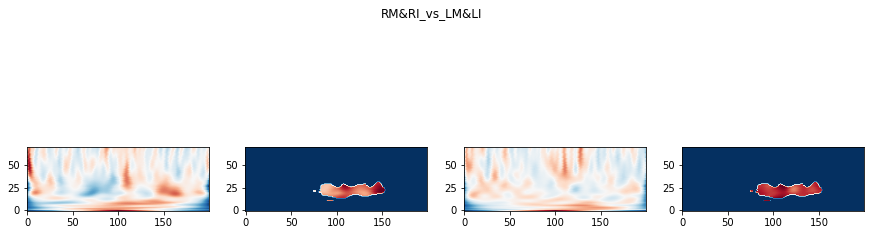

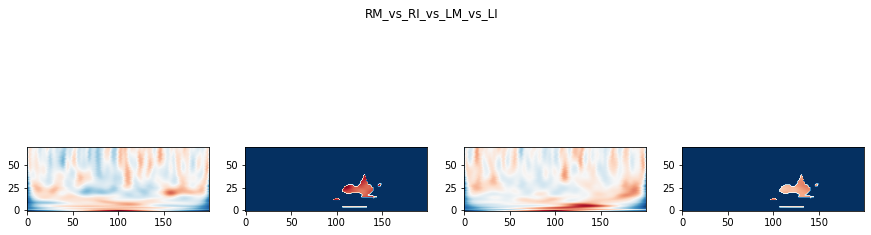

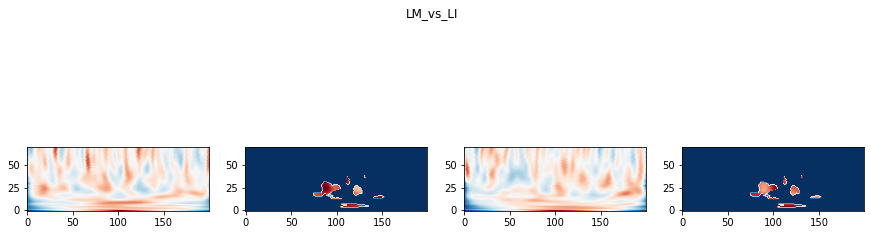

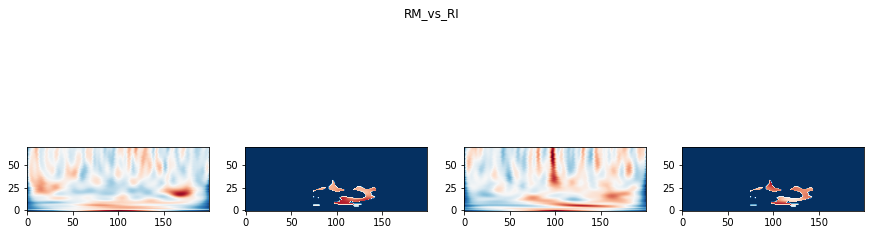

In [29]:
subjects_dir = os.path.join('../', 'Source', 'Subjects')

for cases_to_combine in [
    ['LM LI', 'RM RI'],
    ['LM', 'LI', 'RM', 'RI'],
    ['LM', 'LI'],
    ['RM', 'RI']
]:
    classification_name,\
        classification_postfix,\
        classification_prefix = None, '', ''
    cases_to_combine = [case.split(' ') for case in cases_to_combine]
    cases_to_combine = sorted(cases_to_combine, reverse=True)
    class_names = ['&'.join(sorted(cases_combination, reverse=True)) for cases_combination in cases_to_combine]

    if classification_name is None:
        classification_name = '_vs_'.join(class_names)

    classification_name_formatted = "_".join(list(filter(lambda s: s not in (None, ""), [classification_prefix, classification_name, classification_postfix])))

    tfs = list()
    induceds1 = list()
    induceds2 = list()
    induceds = list()
    for subject_name in os.listdir(subjects_dir):

        if subject_name == 'Pse_Udo':
            continue

        ses = 'B1-B3'
        model = f'LFCNN_train_{ses}'
        subject_parameters_path = os.path.join(subjects_dir, subject_name, model, 'Parameters')
        waveforms1 = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_waveforms.pkl'))
        spatial_parameters1 = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_spatial.pkl'))
        ses = 'B10-B12'
        model = f'LFCNN_train_{ses}'
        subject_parameters_path = os.path.join(subjects_dir, subject_name, model, 'Parameters')
        waveforms2 = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_waveforms.pkl'))
        spatial_parameters2 = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_spatial.pkl'))
        patterns = spatial_parameters1.patterns

        indices1 = list(
            map(
                lambda item: item[0],
                sorted(
                    enumerate(spatial_parameters1.patterns.T),
                    key=lambda item: np.abs(item[1]).sum(0),
                    reverse=True
                )
            )
        )

        pair_found = False
        pat_i = 0
        while not pair_found:
            best_pattern_index = indices1[pat_i]
            best_pattern = patterns[:, best_pattern_index]

            indices2 = list(
                map(
                    lambda item: item[0],
                    sorted(
                        enumerate(spatial_parameters2.patterns.T),
                        key=lambda item: compare(best_pattern, item[1]),
                        reverse=True
                    )
                )
            )
            ratio = compare(best_pattern, spatial_parameters2.patterns[:, indices2[0]])
            if ratio >= .75:
                pair_found = True
            else:
                pat_i += 1

        induced1 = waveforms1.induced[indices1[pat_i], :, :]
        induced2 = waveforms2.induced[indices1[pat_i], :, :]

        induceds.append(InducedsComparer(
            induced1,
            induced2,
            ratio,
            dict(subject_name = subject_name)
        ))
        # draw_inddif(
        #     induceds[-1].induced_cond_1,
        #     induceds[-1].induced_cond_2,
        #     induceds[-1].diff(normalize=True, absolute=True),
        #     title3=f'B10-B12, {induceds[-1].ratio}',
        #     suptitle=subject_name
        # )
    induced_ave_1 = np.array([induced.induced_cond_1 for induced in induceds]).mean(0)
    induced_ave_2 = np.array([induced.induced_cond_2 for induced in induceds]).mean(0)
    diff_ave_abs = np.array([induced.diff(normalize=True, absolute=True) for induced in induceds]).mean(0)
    # draw_inddif(
    #     normal_rows(induced_ave_1),
    #     normal_rows(induced_ave_2),
    #     diff_ave_abs
    # )
    # draw_inddif(
    #     normal_rows(induced_ave_1),
    #     normal_rows(induced_ave_2),
    #     binary_mask(diff_ave_abs, 1.5)
    # )
    mask = binary_mask(diff_ave_abs, 1.5)
    induced_ave_cropped_cond_1 = np.reshape(mask*normal_rows(induced_ave_1), -1)
    induced_ave_cropped_cond_1[induced_ave_cropped_cond_1 != 0]
    induced_ave_cropped_cond_2 = np.reshape(mask*normal_rows(induced_ave_2), -1)
    induced_ave_cropped_cond_2[induced_ave_cropped_cond_2 != 0]
    s, p = sp.stats.ttest_ind(induced_ave_cropped_cond_1, induced_ave_cropped_cond_2)
    # print(p)

    # T_obs, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_test(
    #     # subjects x time x freq
    #     [normal_rows(induced_ave_1), normal_rows(induced_ave_2)],
    #     tail=0,
    #     out_type='mask',
    #     verbose=False,
    #     # stat_fun=lambda x, y: sp.stats.ttest_rel(x, y)[-1]
    # )
    # print(clusters)

    # for p, cluster in zip(cluster_pv, clusters):
    #     if p < .1:
    #         cluster = np.ma.make_mask(cluster)
    #         print(cluster)
    #         fig = mimshow(
    #             normal_rows(induced_ave_1),
    #             cluster*normal_rows(induced_ave_1),
    #             normal_rows(induced_ave_2),
    #             cluster*normal_rows(induced_ave_2)
    #         )
    #         w, h = 15, 5
    #         fig.set_size_inches(w, h)
    cond1, cond2 = list(), list()
    for i, indcomp in enumerate(induceds):
        # plt.xlim(75, 155)
        if classification_name_formatted == 'RM&RI_vs_LM&LI':
            # plt.ylim(10, 40)
            mask[:, :75] = 0
            mask[:, 155:] = 0
            mask[:10, :] = 0
            mask[40:, :] = 0
        else:
            mask[:, :75] = 0
            mask[:, 155:] = 0
            mask[40:, :] = 0
        if i == 0:
            fig = mimshow(
                normal_rows(indcomp.induced_cond_1),
                mask*normal_rows(indcomp.induced_cond_1),
                normal_rows(indcomp.induced_cond_2),
                mask*normal_rows(indcomp.induced_cond_2)
            )
            w, h = 15, 5
            fig.set_size_inches(w, h)
            fig.suptitle(classification_name_formatted)
            # ind_cropped_cond_1 = np.reshape(mask*normal_rows(indcomp.induced_cond_1), -1)
            # ind_cropped_cond_2 = np.reshape(mask*normal_rows(indcomp.induced_cond_2), -1)
            # ind_cropped_cond_1[ind_cropped_cond_1 != 0]
            # ind_cropped_cond_2[ind_cropped_cond_2 != 0]
            # print(ind_cropped_cond_2.shape)
            # s, p = sp.stats.ttest_ind(ind_cropped_cond_1, ind_cropped_cond_2)
            # print(indcomp.meta['subject_name'], p)
        cond1.append((mask*normal_rows(indcomp.induced_cond_1)).sum())
        cond2.append((mask*normal_rows(indcomp.induced_cond_2)).sum())
    s, p = sp.stats.ttest_ind(cond1, cond2)
    print(classification_name_formatted)
    print(p)


In [46]:
import time

subjects_dir = os.path.join('../', 'Source', 'Subjects')
dumb_pics_dir = '/home/user/Downloads/Pics/Dumb/'
for f in os.listdir(dumb_pics_dir):
    os.remove(os.path.join(dumb_pics_dir, f))

for cases_to_combine in [
    ['LM LI', 'RM RI'],
    ['LM', 'LI', 'RM', 'RI'],
    ['LM', 'LI'],
    ['RM', 'RI']
]:
    classification_name,\
        classification_postfix,\
        classification_prefix = None, '', ''
    cases_to_combine = [case.split(' ') for case in cases_to_combine]
    cases_to_combine = sorted(cases_to_combine, reverse=True)
    class_names = ['&'.join(sorted(cases_combination, reverse=True)) for cases_combination in cases_to_combine]

    if classification_name is None:
        classification_name = '_vs_'.join(class_names)

    classification_name_formatted = "_".join(list(filter(lambda s: s not in (None, ""), [classification_prefix, classification_name, classification_postfix])))

    tfs = list()
    induceds1 = list()
    induceds2 = list()
    induceds = list()
    for subject_name in os.listdir(subjects_dir):

        if subject_name == 'Pse_Udo':
            continue

        ses = 'B1-B3'
        model = f'LFCNN_train_{ses}'
        subject_parameters_path = os.path.join(subjects_dir, subject_name, model, 'Parameters')
        waveforms1 = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_waveforms.pkl'))
        spatial_parameters1 = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_spatial.pkl'))
        ses = 'B10-B12'
        model = f'LFCNN_train_{ses}'
        subject_parameters_path = os.path.join(subjects_dir, subject_name, model, 'Parameters')
        waveforms2 = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_waveforms.pkl'))
        spatial_parameters2 = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_spatial.pkl'))
        patterns = spatial_parameters1.patterns

        indices1 = list(
            map(
                lambda item: item[0],
                sorted(
                    enumerate(spatial_parameters1.patterns.T),
                    key=lambda item: np.abs(item[1]).sum(0),
                    reverse=True
                )
            )
        )

        pair_found = False
        pat_i = 0
        while not pair_found:
            best_pattern_index = indices1[pat_i]
            best_pattern = patterns[:, best_pattern_index]

            indices2 = list(
                map(
                    lambda item: item[0],
                    sorted(
                        enumerate(spatial_parameters2.patterns.T),
                        key=lambda item: compare(best_pattern, item[1]),
                        reverse=True
                    )
                )
            )
            ratio = compare(best_pattern, spatial_parameters2.patterns[:, indices2[0]])
            if ratio >= .75:
                pair_found = True
            else:
                pat_i += 1

        induced1 = waveforms1.induced[indices1[pat_i], :, :]
        induced2 = waveforms2.induced[indices1[pat_i], :, :]

        induceds.append(InducedsComparer(
            induced1,
            induced2,
            ratio,
            dict(subject_name = subject_name)
        ))
    induced_ave_1 = np.array([induced.induced_cond_1 for induced in induceds]).mean(0)
    induced_ave_2 = np.array([induced.induced_cond_2 for induced in induceds]).mean(0)
    diff_ave = np.array([induced.diff(normalize=True, absolute=False)[:, 50:150] for induced in induceds]).mean(0)

    data_cond_1 = np.array([
        induced.induced_cond_1[:, 50:150] for induced in induceds
    ])
    data_cond_2 = np.array([
        induced.induced_cond_2[:, 50:150] for induced in induceds
    ])

    T_obs, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_test(
        # subjects x time x freq
        [data_cond_1, data_cond_2],
        tail=0,
        out_type='mask',
        verbose=False,
        #! x.shape = y.shape = (8, 7000) = (8, 70*100) = (n_subjects, n_freqs*n_times); data.shape = (8, 70, 100) = (n_subjects x n_freqs x n_times)
        stat_fun=lambda x, y: sp.stats.ttest_rel(x, y)[0]
        # stat_fun=lambda x, y: print(x.shape, y.shape)
    )

    for cluster_n, (p, cluster) in enumerate(zip(cluster_pv, clusters)):
        plt.imshow(cluster, origin='lower')
        plt.suptitle(f'{classification_name_formatted}\nBinary mask for cluster {cluster_n} ({p})')
        plt.savefig(
            os.path.join(dumb_pics_dir, f'{int(time.time()*10000)}.jpg'), dpi=500
        )
        plt.close()
        # plt.show()
        if p < .1 and cluster.astype(int).sum() > 10:
            for subject_n, (data1, data2) in enumerate(zip(data_cond_1, data_cond_2)):
                data1 = normal_rows(data1)
                data2 = normal_rows(data2)
                vmin = min(data1.min(), data2.min())
                vmax = max(data1.max(), data2.max())
                fig = mimshow(
                    data1,
                    cluster*data1,
                    data2,
                    cluster*data2,
                    titles=['Induced Condition 1', 'Cluster Condition 1', 'Induced Condition 2', 'Cluster Condition 2'],
                    vmin=vmin,
                    vmax=vmax
                )
                w, h = 15, 5
                plt.suptitle(
                    f'{classification_name_formatted}\n'
                    f'Subject {subject_n}; Cluster {cluster_n}; p-value {p}'
                )
                fig.set_size_inches(w, h)
                # plt.show()
                plt.savefig(
                    os.path.join(dumb_pics_dir, f'{int(time.time()*10000)}.jpg'), dpi=500
                )
                plt.close()

images = [
    Image.open(os.path.join(dumb_pics_dir, f))
    for f in os.listdir(dumb_pics_dir)
]
pdf_path = f'/home/user/Downloads/Pics/permutation_testing_output.pdf'
images[0].save(
    pdf_path, "PDF", resolution=100.0, save_all=True, append_images=images[1:]
)


/tmp/ipykernel_203610/1653795479.py:100: RuntimeWarning: Automatic threshold is only valid for stat_fun=None (or f_oneway), got <function <lambda> at 0x7f807d455e50>
  T_obs, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_test(


KeyboardInterrupt: 

In [45]:
import time

subjects_dir = os.path.join('../', 'Source', 'Subjects')
dumb_pics_dir = '/home/user/Downloads/Pics/Dumb/'
for f in os.listdir(dumb_pics_dir):
    os.remove(os.path.join(dumb_pics_dir, f))

for cases_to_combine in [
    ['LM LI', 'RM RI'],
    ['LM', 'LI', 'RM', 'RI'],
    ['LM', 'LI'],
    ['RM', 'RI']
]:
    classification_name,\
        classification_postfix,\
        classification_prefix = None, '', ''
    cases_to_combine = [case.split(' ') for case in cases_to_combine]
    cases_to_combine = sorted(cases_to_combine, reverse=True)
    class_names = ['&'.join(sorted(cases_combination, reverse=True)) for cases_combination in cases_to_combine]

    if classification_name is None:
        classification_name = '_vs_'.join(class_names)

    classification_name_formatted = "_".join(list(filter(lambda s: s not in (None, ""), [classification_prefix, classification_name, classification_postfix])))

    tfs = list()
    induceds1 = list()
    induceds2 = list()
    induceds = list()
    for subject_name in os.listdir(subjects_dir):

        if subject_name == 'Pse_Udo':
            continue

        ses = 'B1-B3'
        model = f'LFCNN_train_{ses}'
        subject_parameters_path = os.path.join(subjects_dir, subject_name, model, 'Parameters')
        waveforms1 = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_waveforms.pkl'))
        spatial_parameters1 = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_spatial.pkl'))
        ses = 'B10-B12'
        model = f'LFCNN_train_{ses}'
        subject_parameters_path = os.path.join(subjects_dir, subject_name, model, 'Parameters')
        waveforms2 = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_waveforms.pkl'))
        spatial_parameters2 = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_spatial.pkl'))
        patterns = spatial_parameters1.patterns

        indices1 = list(
            map(
                lambda item: item[0],
                sorted(
                    enumerate(spatial_parameters1.patterns.T),
                    key=lambda item: np.abs(item[1]).sum(0),
                    reverse=True
                )
            )
        )

        pair_found = False
        pat_i = 0
        while not pair_found:
            best_pattern_index = indices1[pat_i]
            best_pattern = patterns[:, best_pattern_index]

            indices2 = list(
                map(
                    lambda item: item[0],
                    sorted(
                        enumerate(spatial_parameters2.patterns.T),
                        key=lambda item: compare(best_pattern, item[1]),
                        reverse=True
                    )
                )
            )
            ratio = compare(best_pattern, spatial_parameters2.patterns[:, indices2[0]])
            if ratio >= .75:
                pair_found = True
            else:
                pat_i += 1

        induced1 = waveforms1.induced[indices1[pat_i], :, :]
        induced2 = waveforms2.induced[indices1[pat_i], :, :]

        induceds.append(InducedsComparer(
            induced1,
            induced2,
            ratio,
            dict(subject_name = subject_name)
        ))
    induced_ave_1 = np.array([induced.induced_cond_1 for induced in induceds]).mean(0)
    induced_ave_2 = np.array([induced.induced_cond_2 for induced in induceds]).mean(0)
    diff_ave = np.array([induced.diff(normalize=True, absolute=False)[:, 50:150] for induced in induceds]).mean(0)

    data_cond_1 = np.array([
        induced.induced_cond_1[:, 50:150] for induced in induceds
    ])
    data_cond_2 = np.array([
        induced.induced_cond_2[:, 50:150] for induced in induceds
    ])

    T_obs, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_test(
        # subjects x time x freq
        [data_cond_1, data_cond_2],
        tail=0,
        out_type='mask',
        verbose=False,
        #! x.shape = y.shape = (8, 7000) = (8, 70*100) = (n_subjects, n_freqs*n_times); data.shape = (8, 70, 100) = (n_subjects x n_freqs x n_times)
        stat_fun=lambda x, y: sp.stats.ttest_rel(x, y)[0]
        # stat_fun=lambda x, y: print(x.shape, y.shape)
    )

    for cluster_n, (p, cluster) in enumerate(zip(cluster_pv, clusters)):
        cluster_part = cluster.copy().astype('float')
        cluster_part[cluster_part != 0] = np.nan
        cluster_part[cluster_part == 0] = 1
        cluster_part = cluster_part*diff_ave
        fig = mimshow(
            cluster,
            diff_ave,
            [diff_ave, cluster_part],
            titles=['Binary mask', 'Average diff', 'Mapped ave diff'],
            suptitle=f'{classification_name_formatted}\nBinary mask for cluster {cluster_n} ({p})',
            cmaps = ['gist_gray', 'RdBu_r', ['RdBu_r', 'gist_gray']],
        )
        w, h = 15, 5
        fig.set_size_inches(w, h)
        plt.savefig(
            os.path.join(dumb_pics_dir, f'{int(time.time()*10000)}.jpg'), dpi=500
        )
        plt.close()

images = [
    Image.open(os.path.join(dumb_pics_dir, f))
    for f in os.listdir(dumb_pics_dir)
]
pdf_path = f'/home/user/Downloads/Pics/permutation_testing_masks_and_diffs.pdf'
images[0].save(
    pdf_path, "PDF", resolution=100.0, save_all=True, append_images=images[1:]
)


/tmp/ipykernel_203610/3572575038.py:100: RuntimeWarning: Automatic threshold is only valid for stat_fun=None (or f_oneway), got <function <lambda> at 0x7f8077610040>
  T_obs, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_test(
/tmp/ipykernel_203610/3572575038.py:100: RuntimeWarning: Automatic threshold is only valid for stat_fun=None (or f_oneway), got <function <lambda> at 0x7f807c6a39d0>
  T_obs, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_test(
/tmp/ipykernel_203610/3572575038.py:100: RuntimeWarning: Automatic threshold is only valid for stat_fun=None (or f_oneway), got <function <lambda> at 0x7f807d0913a0>
  T_obs, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_test(
/tmp/ipykernel_203610/3572575038.py:100: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_test(
/tmp/ipykernel_203610/3572575038.py:100: RuntimeWarning: Automatic threshold is only valid fo

In [1]:
import time
from time import perf_counter

t1 = perf_counter()
time.sleep(4)
print(perf_counter() - t1)

4.001914846972795
